In [2]:
%pip install onnxruntime

   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.5 MB 991.0 kB/s eta 0:00:14
    --------------------------------------- 0.2/13.5 MB 2.1 MB/s eta 0:00:07
   - -------------------------------------- 0.4/13.5 MB 3.3 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/13.5 MB 5.5 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/13.5 MB 8.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.8/13.5 MB 10.6 MB/s eta 0:00:02
   ----------- ---------------------------- 3.9/13.5 MB 12.6 MB/s eta 0:00:01
   --------------- ------------------------ 5.1/13.5 MB 14.2 MB/s eta 0:00:01
   ------------------ --------------------- 6.1/13.5 MB 15.1 MB/s eta 0:00:01
   ---------------------- ----------------- 7.6/13.5 MB 16.7 MB/s eta 0:00:01
   ------------------------ --------------- 8.3/13.5 MB 16.7 MB/s eta 0:00:01
   ---------------------------- ----------- 9.7/13.5 MB 17.7 MB/s eta 0:00:


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded scaler and ONNX model
✅ Generated 6463 sequences
✅ Calculated anomaly scores
Recommended Critical Threshold: 18.622055
Recommended Warning Threshold: 4.605842
Classification Report (recommended thresholds):
              precision    recall  f1-score   support

    Critical       0.08      0.47      0.13        17
     Warning       0.09      0.26      0.13        31
      Normal       1.00      0.97      0.99      6415

    accuracy                           0.97      6463
   macro avg       0.39      0.57      0.42      6463
weighted avg       0.99      0.97      0.98      6463



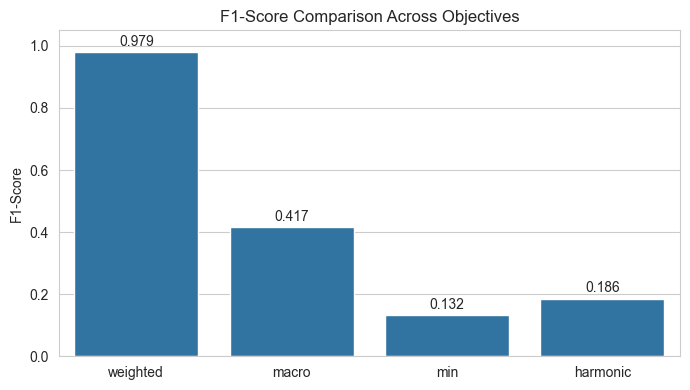

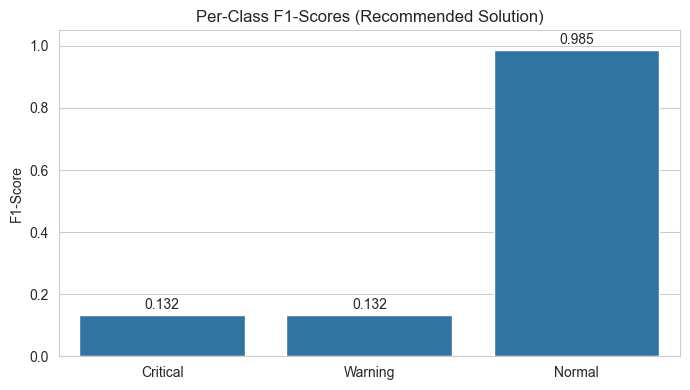

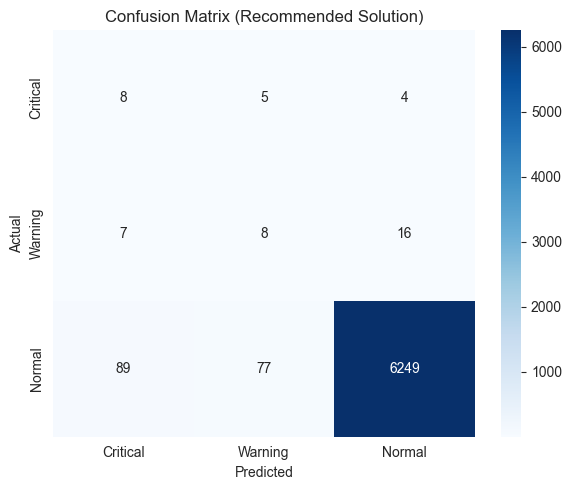

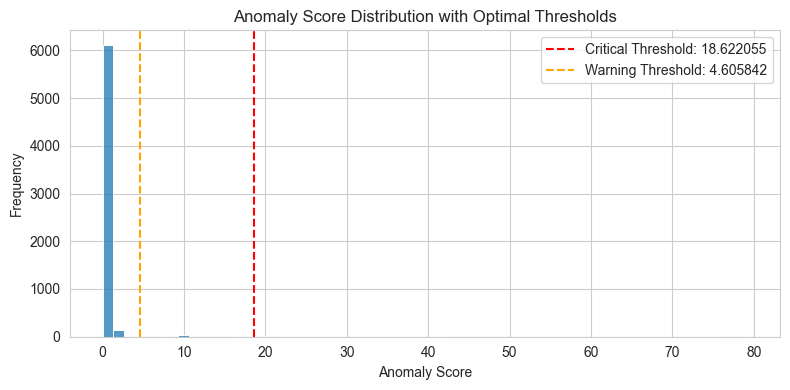

✅ Visualization complete (displayed inline in Jupyter).


In [3]:
# ======================================================
# Full script: load -> inference -> threshold search -> separate visualizations (Jupyter)
# ======================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import onnxruntime as ort

# ======================================================
# Configuration
# ======================================================
SEQUENCE_LENGTH = 30
NUMERICAL_COLS = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
LABEL_ORDER = ['Critical', 'Warning', 'Normal']
SCALER_PATH = 'scaler_fit.save'
ONNX_MODEL_PATH = 'lstm_autoencoder_model_opset11.onnx'
VALIDATION_FILES = ['./../../data/dev101_resample10T_flex.csv',
                    './../../data/dev102_resample10T_flex.csv']

sns.set_style('whitegrid')

# ======================================================
# Helpers
# ======================================================
def create_sequences_by_device(df, seq_len, cols, return_index=False):
    sequences, device_ids, timestamps, indices = [], [], [], []
    scaled_cols = [f'scaled_{c}' for c in cols]
    for dev, grp in df.groupby('devID'):
        grp = grp.sort_values('timestamp')
        vals = grp[scaled_cols].values
        times = grp['timestamp'].values
        idxs = grp.index.values
        for i in range(len(vals) - seq_len + 1):
            sequences.append(vals[i:i+seq_len])
            device_ids.append(dev)
            timestamps.append(times[i+seq_len-1])
            if return_index:
                indices.append(idxs[i+seq_len-1])
    if return_index:
        return np.array(sequences, dtype=np.float32), device_ids, timestamps, indices
    return np.array(sequences, dtype=np.float32), device_ids, timestamps

def classify_risk(scores, crit_thr, warn_thr):
    # returns labels according to thresholds (higher score -> more anomalous)
    conds = [scores > crit_thr,
             (scores <= crit_thr) & (scores > warn_thr),
             scores <= warn_thr]
    return np.select(conds, LABEL_ORDER, default='Normal')

def evaluate_thresholds(df, crit_thr, warn_thr):
    y_pred = classify_risk(df['anomaly_score'].values, crit_thr, warn_thr)
    y_true = df['true_label'].values
    f1_w = f1_score(y_true, y_pred, average='weighted', labels=LABEL_ORDER)
    f1_m = f1_score(y_true, y_pred, average='macro', labels=LABEL_ORDER)
    f1_c = f1_score(y_true, y_pred, average=None, labels=LABEL_ORDER)
    f1_min = f1_c.min()
    f1_h = len(f1_c) / np.sum(1.0 / (f1_c + 1e-8))
    return {'f1_weighted': f1_w, 'f1_macro': f1_m,
            'f1_per_class': f1_c, 'f1_min': f1_min,
            'f1_harmonic': f1_h, 'y_pred': y_pred}

# ======================================================
# Load scaler & ONNX model
# ======================================================
scaler = joblib.load(SCALER_PATH)
session = ort.InferenceSession(ONNX_MODEL_PATH)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print("✅ Loaded scaler and ONNX model")

# ======================================================
# Load and preprocess validation data
# ======================================================
frames = [pd.read_csv(f) for f in VALIDATION_FILES]
df_val = pd.concat(frames, ignore_index=True)
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_val = df_val.sort_values('timestamp').reset_index(drop=True)
df_val['label'] = df_val['label'].fillna('Normal')

# Scale features
scaled = scaler.transform(df_val[NUMERICAL_COLS])
for i, c in enumerate(NUMERICAL_COLS):
    df_val[f'scaled_{c}'] = scaled[:, i]

# Create sequences
X_val, dev_ids, times, idxs = create_sequences_by_device(df_val, SEQUENCE_LENGTH, NUMERICAL_COLS, return_index=True)
print(f"✅ Generated {len(X_val)} sequences")

# ======================================================
# Run ONNX Inference
# ======================================================
def run_onnx_inference(session, sequences):
    scores = []
    for x in sequences:
        x_input = np.expand_dims(x, axis=0).astype(np.float32)  # (1, SEQUENCE_LENGTH, features)
        y_pred = session.run([output_name], {input_name: x_input})[0]
        # y_pred shape may be (1, seq_len, features) or similar depending model
        # ensure shapes align
        mse = np.mean((x_input - y_pred)**2)
        scores.append(mse)
    return np.array(scores)

anom_scores = run_onnx_inference(session, X_val)
print("✅ Calculated anomaly scores")

# ======================================================
# Build results DataFrame
# ======================================================
df_seq = pd.DataFrame({'devID': dev_ids, 'timestamp': times, 'index': idxs})
df_seq['true_label'] = df_val.loc[df_seq['index'], 'label'].replace(
    {'critical':'Critical','warning':'Warning','normal':'Normal'}).values
df_seq['anomaly_score'] = anom_scores
df_seq = df_seq[df_seq['true_label'].isin(LABEL_ORDER)].reset_index(drop=True)

# ======================================================
# Threshold Optimization (Grid search)
# ======================================================
s_min, s_max = df_seq['anomaly_score'].min(), df_seq['anomaly_score'].max()
percentiles = np.linspace(0.1, 99.9, 200)
cands = np.percentile(df_seq['anomaly_score'], percentiles)
for p in [90,95,97,99]:
    v = np.percentile(df_seq['anomaly_score'], p)
    rng = s_max - s_min
    cands = np.concatenate([cands, v + np.array([-0.01,0,0.01])*rng])
cands = np.unique(np.clip(cands, s_min, s_max))

best = {'balanced': {'score':0}}
for crit in cands:
    for warn in cands:
        if warn >= crit: continue
        res = evaluate_thresholds(df_seq, crit, warn)
        bal = 0.6*res['f1_min'] + 0.4*res['f1_harmonic']
        if bal > best['balanced']['score']:
            best['balanced'].update({'score': bal, 'crit': crit, 'warn': warn, 'res': res})

opt = best['balanced']
print(f"Recommended Critical Threshold: {opt['crit']:.6f}")
print(f"Recommended Warning Threshold: {opt['warn']:.6f}")
print("Classification Report (recommended thresholds):")
print(classification_report(df_seq['true_label'], opt['res']['y_pred'], labels=LABEL_ORDER, zero_division=0))

# ======================================================
# Visualization (Separate figures for Jupyter)
# ======================================================
# We'll draw 4 separate figures and call plt.show() so Jupyter displays each inline.

# 1) F1-Score Comparison Across Objectives
f1_scores_per_class = opt['res']['f1_per_class']
f1_weighted = opt['res']['f1_weighted']
f1_macro = opt['res']['f1_macro']
f1_min = opt['res']['f1_min']
f1_harmonic = opt['res']['f1_harmonic']

plt.figure(figsize=(7,4))
objs = ['weighted', 'macro', 'min', 'harmonic']
vals = [f1_weighted, f1_macro, f1_min, f1_harmonic]
sns.barplot(x=objs, y=vals)
plt.ylim(0,1.05)
plt.title("F1-Score Comparison Across Objectives")
plt.ylabel("F1-Score")
for i, v in enumerate(vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()
plt.close()

# 2) Per-Class F1-Scores
plt.figure(figsize=(7,4))
sns.barplot(x=LABEL_ORDER, y=f1_scores_per_class)
plt.ylim(0,1.05)
for i, v in enumerate(f1_scores_per_class):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.title("Per-Class F1-Scores (Recommended Solution)")
plt.ylabel("F1-Score")
plt.tight_layout()
plt.show()
plt.close()

# 3) Confusion Matrix
cm = confusion_matrix(df_seq['true_label'], opt['res']['y_pred'], labels=LABEL_ORDER)
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_ORDER, yticklabels=LABEL_ORDER, cbar=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix (Recommended Solution)")
plt.tight_layout()
plt.show()
plt.close()

# 4) Anomaly Score Distribution with thresholds
plt.figure(figsize=(8,4))
sns.histplot(df_seq['anomaly_score'], bins=60, kde=False)
plt.axvline(opt['crit'], linestyle='--', color='red', label=f"Critical Threshold: {opt['crit']:.6f}")
plt.axvline(opt['warn'], linestyle='--', color='orange', label=f"Warning Threshold: {opt['warn']:.6f}")
plt.title("Anomaly Score Distribution with Optimal Thresholds")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

print("✅ Visualization complete (displayed inline in Jupyter).")
